In [1]:
# import libraries ต่าง ๆ ที่จะใช้
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # ใช้ในการแบ่งข้อมูล
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from torchmetrics.classification import MulticlassPrecisionRecallCurve
from torch.utils.data import WeightedRandomSampler

In [2]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/3 cleaned_dataset_1output_YorNADR.csv")
df

,ADR,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,Cohort ethnicity_Mongol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,p2-53-M,p2-53-N,p2-53-P,p2-53-Q,p2-53-R,p2-53-S,p2-53-T,p2-53-V,p2-53-W,p2-53-Y
0,1.0,0,0,1,0,12.739529,-1.532351,12.739529,0.357593,0.748363,...,0,0,0,0,0,0,0,0,0,1
1,1.0,0,0,1,0,12.739529,-1.532351,12.739529,0.357593,0.748363,...,0,0,0,0,0,0,0,0,0,1
2,1.0,0,0,1,0,12.739529,-1.532351,12.739529,0.357593,0.748363,...,0,0,0,0,0,0,0,0,0,1
3,1.0,0,0,0,1,7.915334,-0.518197,7.915334,0.030546,0.813810,...,0,0,0,0,0,0,0,0,0,1
4,1.0,0,0,0,1,12.739529,-1.532351,12.739529,0.357593,0.748363,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13096,0.0,0,0,0,1,13.134491,-3.247416,13.134491,0.183634,0.782958,...,0,0,0,0,0,0,0,0,0,1
13097,0.0,0,0,0,1,13.134491,-3.247416,13.134491,0.183634,0.782958,...,0,0,0,0,0,0,0,0,0,1
13098,0.0,0,0,0,1,13.134491,-3.247416,13.134491,0.183634,0.782958,...,0,0,0,0,0,0,0,0,0,1
13099,0.0,0,0,0,1,13.134491,-3.247416,13.134491,0.183634,0.782958,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# define get_dataset()
def get_dataset(df, BATCHSIZE):
    #from torchsampler import ImbalancedDatasetSampler
    df_labels = df.iloc[:, 0]
    df_input = df.iloc[:, 1:]

    np_input = df_input.to_numpy()
    np_labels = df_labels.to_numpy()

    #train test split
    train_data, test_data, train_labels, test_labels = train_test_split(np_input, np_labels, test_size=0.2, random_state=128, stratify=np_labels, shuffle = True)
    
    print('train_label data distribution 0/1: {}/{}'.format(
    len(np.where(train_labels == 0)[0]), len(np.where(train_labels == 1)[0])))
    
    print('test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(test_labels == 0)[0]), len(np.where(test_labels == 1)[0])))

    #calculate weight for each class in train_labels
    weight = (1/pd.DataFrame(train_labels).value_counts()).tolist()
    
    #create weight array for train_labels
    sample_weights = np.array([weight[int(t)] for t in train_labels])
    
    #assign weight to Weighted Random Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)
    
    #แปลง numpy เข้า TensorDataSet และ DataLoader
    train_dataset = TensorDataset(torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).float())
    test_dataset = TensorDataset(torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).float())
    train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=test_labels.shape[0])

    #loop ดูภาพรวมของ train_loader
    for i, (data, target) in enumerate(train_loader):
        print("batch index {}, 0/1: {}/{}".format(
            i,
            len(np.where(target.numpy() == 0)[0]),
            len(np.where(target.numpy() == 1)[0])))

    return train_loader, test_loader

In [7]:
# define CreateModel()
def CreateModel(lr,dropout_rate):
    model = nn.Sequential(
        nn.Linear(train_loader.dataset.tensors[0].shape[1],1024), 
        #nn.Dropout(dropout_rate),
        nn.ReLU(),
        nn.Linear(1024,512),
        #nn.Dropout(dropout_rate),
        nn.ReLU(),
        nn.Linear(512,64),
        nn.ReLU(),
        nn.Linear(64,1),
        nn.Sigmoid()
    )

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #loss_function
    loss_fn = nn.BCELoss()

    return model,optimizer,loss_fn

model,optimizer,loss_fn = CreateModel(0.001,0.2)
model

Sequential(
  (0): Linear(in_features=2480, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
  (7): Sigmoid()
)

In [6]:
# Define the model hyperparameters
CLASSES = 1
BATCHSIZE = 256 #เดิมใช้ 1024
LEARNING_RATE = 2e-6
DROPOUT_RATE = 0
EPOCHS = 1000 #เดิมใช้ 500
DIR = os.getcwd()
dirname = "logs_test20_SIGMOID" #แก้ตรงนี้ทุกครั้งเวลาเปลี่ยน hyperparameters ต่าง ๆ จะได้แยกเก็บ study !
train_loader, test_loader = get_dataset(df,BATCHSIZE)
loss_fn = nn.BCELoss() #ไม่ได้แถม sigmoid มาด้วย!!!!!

train_label data distribution 0/1: 6767/3713
test_labels data distribution 0/1: 1693/928
batch index 0, 0/1: 131/125
batch index 1, 0/1: 139/117
batch index 2, 0/1: 114/142
batch index 3, 0/1: 136/120
batch index 4, 0/1: 129/127
batch index 5, 0/1: 116/140
batch index 6, 0/1: 128/128
batch index 7, 0/1: 136/120
batch index 8, 0/1: 124/132
batch index 9, 0/1: 119/137
batch index 10, 0/1: 131/125
batch index 11, 0/1: 125/131
batch index 12, 0/1: 138/118
batch index 13, 0/1: 115/141
batch index 14, 0/1: 120/136
batch index 15, 0/1: 129/127
batch index 16, 0/1: 131/125
batch index 17, 0/1: 140/116
batch index 18, 0/1: 126/130
batch index 19, 0/1: 131/125
batch index 20, 0/1: 129/127
batch index 21, 0/1: 134/122
batch index 22, 0/1: 124/132
batch index 23, 0/1: 124/132
batch index 24, 0/1: 124/132
batch index 25, 0/1: 108/148
batch index 26, 0/1: 124/132
batch index 27, 0/1: 133/123
batch index 28, 0/1: 126/130
batch index 29, 0/1: 131/125
batch index 30, 0/1: 132/124
batch index 31, 0/1: 1

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


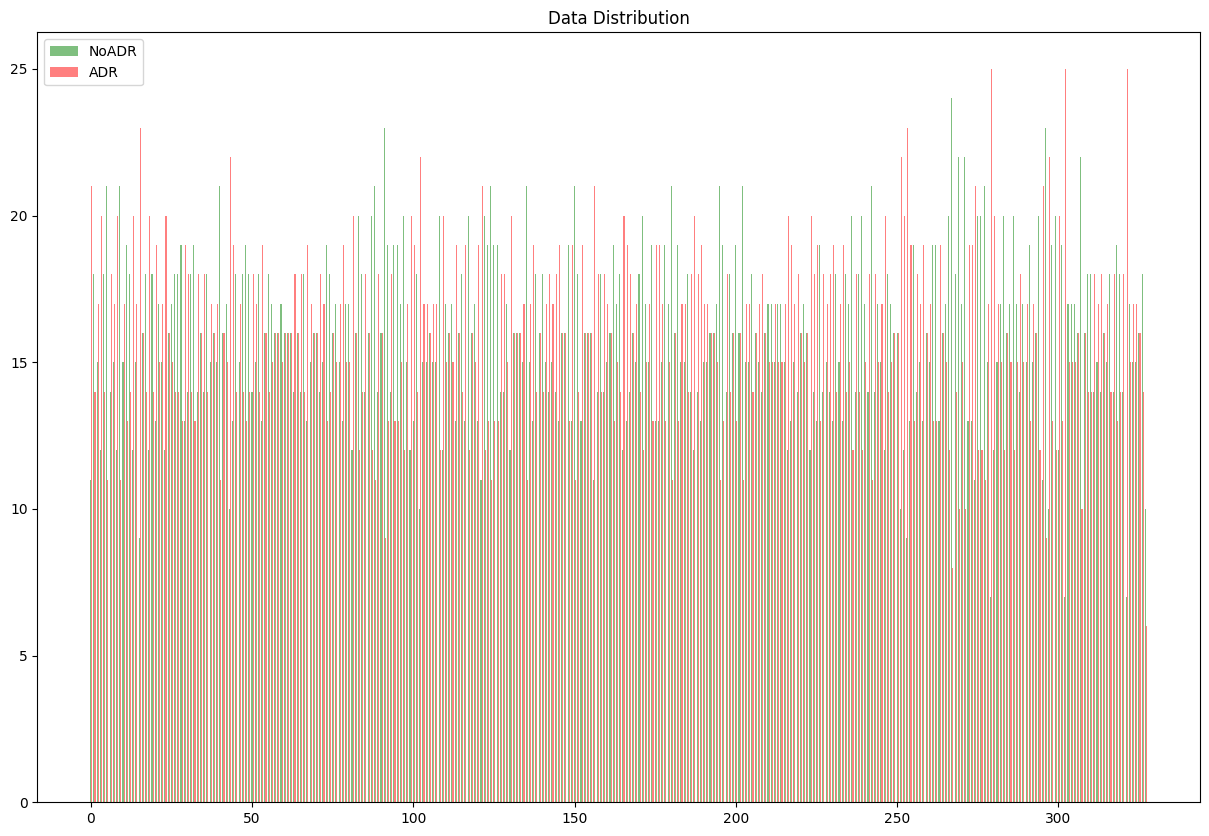

In [6]:
# check class distribution
def get_distribution_graph(dataloader):

    batch_no = [x+1 for x in range(len(dataloader))]
    class_0_count = []
    class_1_count = []
    batch_count = []

    for i, (data,target) in enumerate(dataloader):
        tocount = pd.DataFrame(target.numpy()).value_counts()
        batch_count.append(i+1)
        class_0_count.append(tocount[0.0])
        class_1_count.append(tocount[1.0])

    X_axis = np.arange(len(batch_count))

    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.set_xlabel="Batch Number"
    ax.set_ylabel="No. Datapoints"
    ax.bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
    ax.bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
    #ax.set_xticks(X_axis+width)
    ax.legend()

    ax.set_title("Data Distribution")
    fig.show()

get_distribution_graph(train_loader)


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


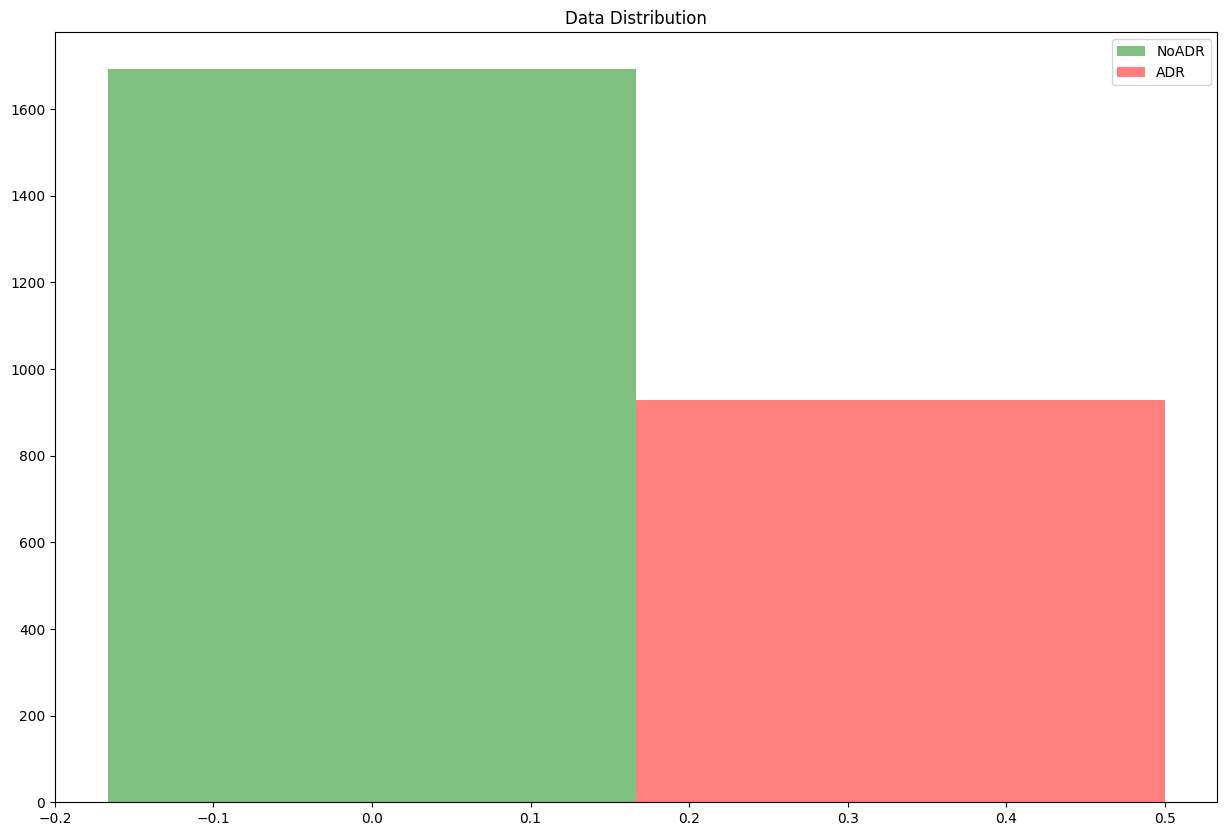

In [7]:
get_distribution_graph(test_loader)

In [12]:
# optuna create model

import os

import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score


optuna.trial.besttrial

AttributeError: module 'optuna.trial' has no attribute 'besttrial'

In [10]:
# optuna create model

import os

import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device

#N_TRAIN_EXAMPLES = len(train_loader.dataset.tensors[0])
#N_VALID_EXAMPLES = len(test_loader.dataset.tensors[0])


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3) #อย่าลืมบวก 1 เพราะ append ไปก่อนเข้า loop แล้ว
    layers = []
    in_features = train_loader.dataset.tensors[0].shape[1]
    layers.append(nn.Linear(in_features, 1024)) # 1024 nodes in the first layer เพื่อบังคับไม่ให้ layer แรกเล็กเกินไป
    in_features = 1024 #จำนวนที่จะ input เข้าไปยัง hidden layer ที่ 2
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 5, 1024) 
        layers.append(nn.Linear(in_features, out_features))
       
        layers.append(nn.Sigmoid())
        
        #p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5) (ไม่ต้อง optimize)
        #layers.append(nn.Dropout(p)) (ไม่ต้องใส่ dropout)

        in_features = out_features
    layers.append(nn.Linear(in_features, 2048)) #เพิ่มเพ่อบังคับให้ layer สุดท้าย 2048 ตามผลของ optuna
    layers.append(nn.ReLU()) 
    layers.append(nn.Linear(2048, CLASSES)) #รับ 2048 แล้วออกมาเป็น 1 output ผ่าน sigmoid
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)



def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"]) #ให้เลือกแค่ Adam อย่างเดียว ไม่ได้ลบไว้เพราะเผื่อจะใส่ SGD ให้ optuna ลองเลือก
    #lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True) (ไม่ต้อง optimize)
    lr = LEARNING_RATE #ใช้ lr ที่ define ไว้ (ไม่ต้อง optimize)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    run_name = "trial-%d" % trial.number
    run_dir = os.path.join(dirname, run_name) # This is the dir used in tensorboard_callback of optuna


    # Training of the model.
    for epoch in range(EPOCHS):
        running_loss = []
        running_train_acc = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break


            data = data.float().to(device)
            target = target.float().to(device)

            optimizer.zero_grad()
            output = model(data)
            output = output.flatten()
            
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
    
            running_loss.append(loss.item()) 

            with torch.no_grad():
                target = target.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                train_acc = correct/len(target)
                train_acc = round(train_acc, 8)
                running_train_acc.append(train_acc)
        train_acc = np.mean(running_train_acc)

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # # Limiting validation data.
                # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #     break
                data = data.float().to(device)
                target = target.float().to(device)               
                output = model(data)
                output = output.flatten()
                data = data.flatten()
                test_loss = loss_fn(output, target)
                output = torch.round(output)
                correct = (output == target).sum().item()
                
                # # Get the index of the max log-probability.
                # pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
        #accuracy = correct/len(valid_loader.dataset)
            test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)
            train_loss = np.mean(running_loss)

            
            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
        
            test_loss = test_loss.cpu().detach().numpy()
   


            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)

        print(f"train accuracy: {train_acc}, test accuracy:{test_acc} train loss:{round(train_loss,8)}, test loss:{round(test_loss.item(),8)}, test precision: {test_precision},test recall: {test_recall_score},test f1: {test_f1_score}")
        with tf.summary.create_file_writer(run_dir).as_default():
            tf.summary.scalar("train loss", train_loss, step=epoch)
            tf.summary.scalar("test loss", test_loss, step=epoch) 
            tf.summary.scalar("test acc", test_acc, step=epoch)
            tf.summary.scalar("test Precision", test_precision, step=epoch)
            tf.summary.scalar("test f1_score", test_f1_score, step=epoch)
            tf.summary.scalar("test recall_score", test_recall_score, step=epoch)
        trial.report(test_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    torch.save(model.state_dict(),f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")
    return train_loss

if __name__ == "__main__":
    tensorboard_callback = TensorBoardCallback(dirname = dirname, metric_name="target")
    pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3)
    study = optuna.create_study(study_name = dirname, directions=["minimize"],sampler=TPESampler(),storage='sqlite:///optuna.sqlite3',pruner=pruner, load_if_exists=True)
    study.optimize(objective, n_trials=1000, timeout=None)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:155: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
[I 2023-04-02 19:49:42,786] Using an existing study with name 'logs_test20_SIGMOID' instead of creating a new one.


train accuracy: 0.507126524390244, test accuracy:0.38992750858450975 train loss:0.69410898, test loss:61.00724792, test precision: 0.8599137931034483,test recall: 0.35200705778561975,test f1: 0.4995305164319249
train accuracy: 0.5083396848780488, test accuracy:0.6470812666921022 train loss:0.69236437, test loss:35.29187393, test precision: 0.008620689655172414,test recall: 0.6153846153846154,test f1: 0.017003188097768334
train accuracy: 0.4993267275609756, test accuracy:0.6470812666921022 train loss:0.69253965, test loss:35.29187393, test precision: 0.008620689655172414,test recall: 0.6153846153846154,test f1: 0.017003188097768334
train accuracy: 0.5068152946341464, test accuracy:0.38992750858450975 train loss:0.69203416, test loss:61.00724792, test precision: 0.8599137931034483,test recall: 0.35200705778561975,test f1: 0.4995305164319249
train accuracy: 0.5027248475609757, test accuracy:0.38992750858450975 train loss:0.69196448, test loss:61.00724792, test precision: 0.859913793103448

[W 2023-04-02 19:51:06,829] Trial 1 failed with parameters: {'n_layers': 1, 'n_units_l0': 975, 'optimizer': 'Adam'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_14292\1157689184.py", line 89, in objective
    loss.backward()
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\_tensor.py", line 489, in backward
    self, gradient, retain_graph, create_graph, inputs=inputs
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\autograd\__init__.py", line 199, in backward
    allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2023-04-02 19:51:06,829] Trial 1 failed with value None.


KeyboardInterrupt: 

# ของเก่า

In [96]:
for x in train_loader:
    with torch.no_grad():
        input = x[0].float().to(device)
        x = nn.Linear(input,1024)
    break


TypeError: empty(): argument 'size' must be tuple of SymInts, but found element of type Tensor at pos 2

In [693]:
writer = SummaryWriter()
trend = ""

#trainAcc,testAcc,trainLoss = TrainTest()


allepoch_train_loss = []
allepoch_test_loss = []
allepoch_test_acc = []
allepoch_train_acc = []


count = 0

for epoch_i in range(epochs):
    #print(f"Epochs: {epoch_i+1}")
    #print("----")
    #batch_no = 0
    running_loss = [] #clear running loss ทุกครั้ง
    running_train_acc = []
    for batch in train_loader:

        model.train().to(device)

        #batch_no += train_loader.batch_size

        train_data, train_label = batch
        train_data = train_data.float().to(device)
        train_label = train_label.float().to(device)
        #train_label = train_label.reshape((len(train_label)),1)

        optimizer.zero_grad()
        outputs = model(train_data)
        outputs = outputs.flatten()
        loss = loss_fn(outputs, train_label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item()) 
        
        #if batch_no % 100 == 0:
            #print(f"Loss: {loss.item():>e} Batch: {batch_no:>5d}/{train_loader.batch_size*len(train_loader):>5d}")


        #train accuracy
        with torch.no_grad():
            #outputs = model(train_data)
            #outputs_sigmoid = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            #_, predicted = torch.max(outputs, 1)
            #train_label = torch.max(train_label, 1)
            outputs = outputs.flatten()
            train_label = train_label.flatten()
            correct = (outputs == train_label).sum().item()
            train_accuracy = correct/len(train_label)
            train_accuracy = round(train_accuracy, 8)
            running_train_acc.append(train_accuracy)
        train_acc = np.mean(running_train_acc)
        allepoch_train_acc.append(train_acc)
        
    model.eval()
    #test accuracy
    testacc = []
    for batch in test_loader:
        test_data, test_label = batch
        test_label = test_label.float().to(device)
        test_data = test_data.float().to(device)
        with torch.no_grad():
            outputs = model(test_data).to(device)
            
            #outputs_sigmoid = torch.sigmoid(outputs)
            
            #test_label = torch.max(test_label, 1)\
            outputs = outputs.flatten()
            test_label = test_label.flatten()
            #_, predicted = torch.max(outputs, 1)
            test_loss = loss_fn(outputs, test_label)

            outputs = torch.round(outputs)
            correct = (outputs == test_label).sum().item()
            test_loss = round(test_loss.item(),8)
            test_accuracy = correct/len(test_label)
            test_accuracy = round(test_accuracy,8)
            allepoch_test_acc.append(test_accuracy)
            allepoch_test_loss.append(test_loss)
    
    train_loss = round(np.mean(running_loss),8)
    allepoch_train_loss.append(train_loss)

    writer.add_scalars('Accuracy', {
        'train accuracy':train_accuracy*100,
        'test accuracy': test_accuracy*100
        }, epoch_i+1)
    

    writer.add_scalars('Loss', {
        'train loss':np.mean(running_loss),
        'test loss': test_loss
        }, epoch_i+1)


    print(f"{epoch_i} {trend}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train_Accuracy: {train_accuracy*100}, Test_Accuracy: {test_accuracy*100}")

    if epoch_i > 3:
        if allepoch_train_loss[epoch_i-2] - allepoch_train_loss[epoch_i-1] <= 0:
            count += 1
            trend = "Down"
        else:
            trend = "UP!!"
            count = 0

        if count == 20:
            print(f"Early Stopped, loss not increasing for {count} times")
            break
    else:
        trend = "Not yet >3 epoch"


0 , Train Loss: 50.4695717, Test Loss: 64.59366608, Train_Accuracy: 51.785714000000006, Test_Accuracy: 35.406333000000004
1 Not yet >3 epoch, Train Loss: 49.90880882, Test Loss: 64.59366608, Train_Accuracy: 53.571429, Test_Accuracy: 35.406333000000004
2 Not yet >3 epoch, Train Loss: 50.6832535, Test Loss: 64.59366608, Train_Accuracy: 51.785714000000006, Test_Accuracy: 35.406333000000004
3 Not yet >3 epoch, Train Loss: 50.43554008, Test Loss: 64.59366608, Train_Accuracy: 45.535714, Test_Accuracy: 35.406333000000004
4 Not yet >3 epoch, Train Loss: 50.76627834, Test Loss: 64.59366608, Train_Accuracy: 47.321428999999995, Test_Accuracy: 35.406333000000004
5 UP!!, Train Loss: 50.07077529, Test Loss: 64.59366608, Train_Accuracy: 59.821429, Test_Accuracy: 35.406333000000004
6 Down, Train Loss: 49.43243687, Test Loss: 64.59366608, Train_Accuracy: 53.571429, Test_Accuracy: 35.406333000000004
7 UP!!, Train Loss: 50.49814899, Test Loss: 64.59366608, Train_Accuracy: 48.214286, Test_Accuracy: 35.406

KeyboardInterrupt: 

In [569]:

import numpy as np
import matplotlib.pyplot as plt


def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):

        idxs = batch[0][:, 0].tolist()
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen


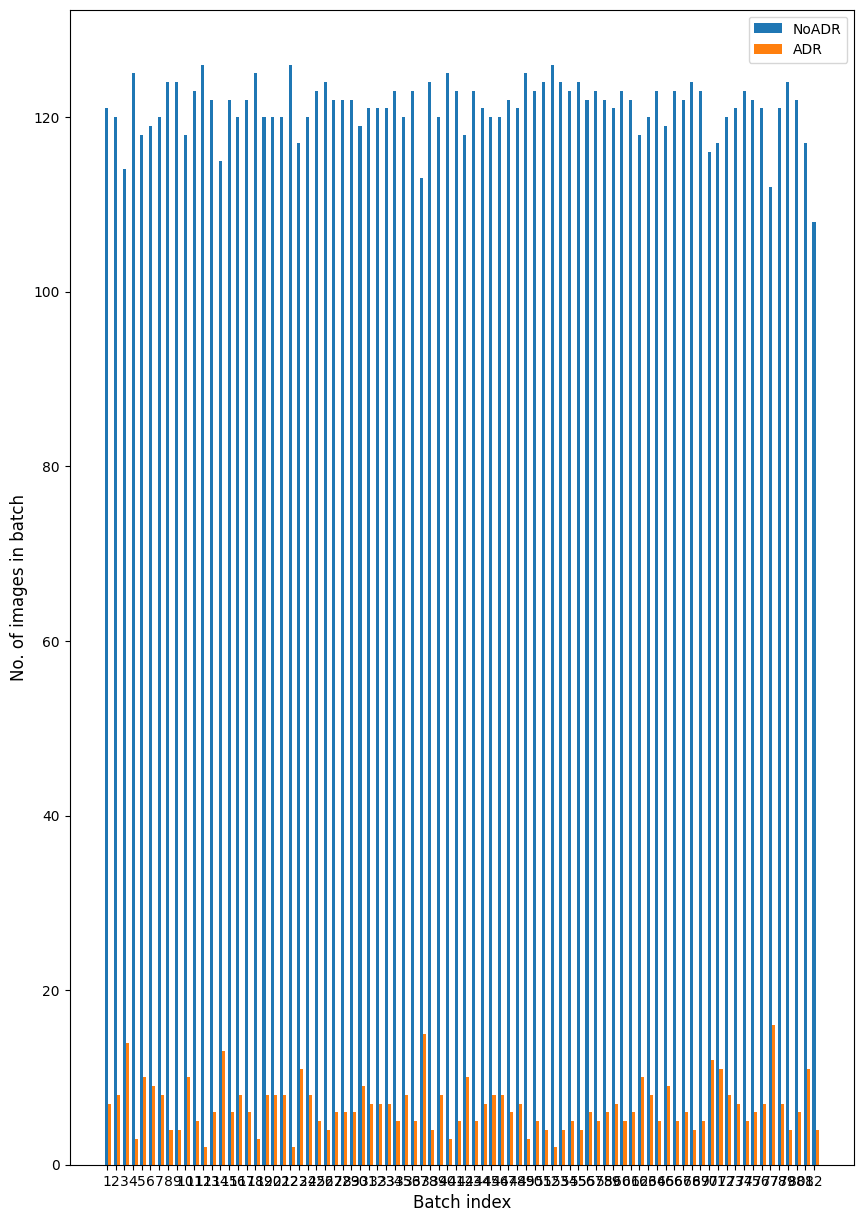

Avg Proportion of NoADR per batch: 12.109756097560975
Avg Proportion of ADR per batch: 0.6707317073170732
Num. unique images seen: 2/10480


([121,
  120,
  114,
  125,
  118,
  119,
  120,
  124,
  124,
  118,
  123,
  126,
  122,
  115,
  122,
  120,
  122,
  125,
  120,
  120,
  120,
  126,
  117,
  120,
  123,
  124,
  122,
  122,
  122,
  119,
  121,
  121,
  121,
  123,
  120,
  123,
  113,
  124,
  120,
  125,
  123,
  118,
  123,
  121,
  120,
  120,
  122,
  121,
  125,
  123,
  124,
  126,
  124,
  123,
  124,
  122,
  123,
  122,
  121,
  123,
  122,
  118,
  120,
  123,
  119,
  123,
  122,
  124,
  123,
  116,
  117,
  120,
  121,
  123,
  122,
  121,
  112,
  121,
  124,
  122,
  117,
  108],
 [7,
  8,
  14,
  3,
  10,
  9,
  8,
  4,
  4,
  10,
  5,
  2,
  6,
  13,
  6,
  8,
  6,
  3,
  8,
  8,
  8,
  2,
  11,
  8,
  5,
  4,
  6,
  6,
  6,
  9,
  7,
  7,
  7,
  5,
  8,
  5,
  15,
  4,
  8,
  3,
  5,
  10,
  5,
  7,
  8,
  8,
  6,
  7,
  3,
  5,
  4,
  2,
  4,
  5,
  4,
  6,
  5,
  6,
  7,
  5,
  6,
  10,
  8,
  5,
  9,
  5,
  6,
  4,
  5,
  12,
  11,
  8,
  7,
  5,
  6,
  7,
  16,
  7,
  4,
  6,
  11,
  4],
 [

In [570]:
visualise_dataloader(train_loader,{0:"NoADR",1:"ADR"})

In [304]:
weight = 1/df['ADR'].value_counts()

0.0    8460
1.0    4641
Name: ADR, dtype: int64

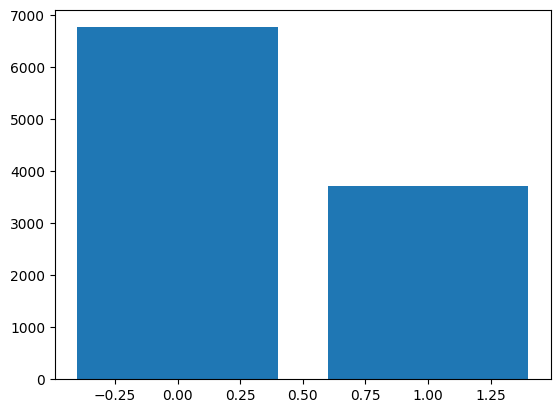

In [571]:
to_plot = pd.DataFrame(train_loader.dataset.tensors[1].numpy()).value_counts()
to_plot2  = pd.DataFrame(test_loader.dataset.tensors[1].numpy()).value_counts()

def get_distribution(tensor):
    df = pd.DataFrame(tensor.numpy()).value_counts()
    fig, ax =plt.subplots()
    ax.bar([0,1],df.values)


    plt.show()
    
get_distribution(train_loader.dataset.tensors[1])

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


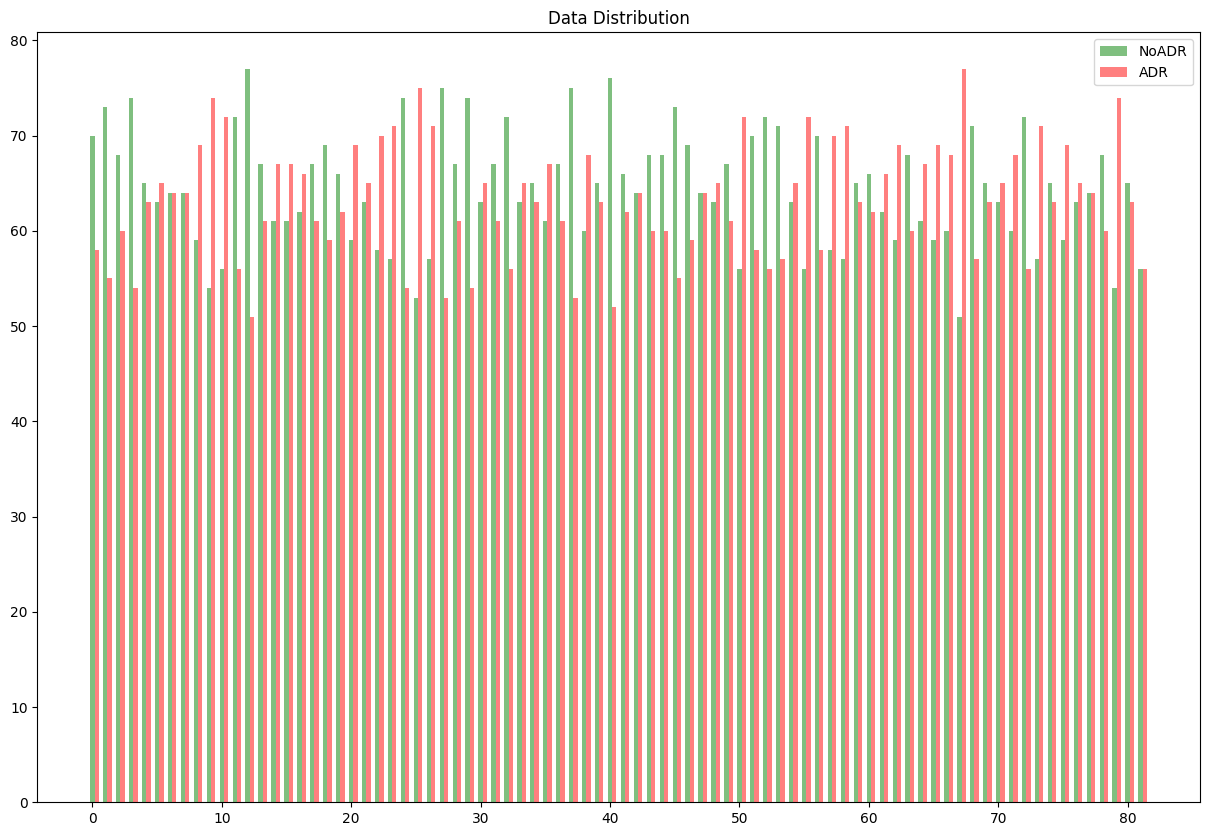

In [686]:
get_distribution_graph(train_loader)

In [635]:
X_axis

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

In [626]:
[x - 0.3 for x in batch_count]

[0.7,
 1.7,
 2.7,
 3.7,
 4.7,
 5.7,
 6.7,
 7.7,
 8.7,
 9.7,
 10.7,
 11.7,
 12.7,
 13.7,
 14.7,
 15.7,
 16.7,
 17.7,
 18.7,
 19.7,
 20.7,
 21.7,
 22.7,
 23.7,
 24.7,
 25.7,
 26.7,
 27.7,
 28.7,
 29.7,
 30.7,
 31.7,
 32.7,
 33.7,
 34.7,
 35.7,
 36.7,
 37.7,
 38.7,
 39.7,
 40.7,
 41.7,
 42.7,
 43.7,
 44.7,
 45.7,
 46.7,
 47.7,
 48.7,
 49.7,
 50.7,
 51.7,
 52.7,
 53.7,
 54.7,
 55.7,
 56.7,
 57.7,
 58.7,
 59.7,
 60.7,
 61.7,
 62.7,
 63.7,
 64.7,
 65.7,
 66.7,
 67.7,
 68.7,
 69.7,
 70.7,
 71.7,
 72.7,
 73.7,
 74.7,
 75.7,
 76.7,
 77.7,
 78.7,
 79.7,
 80.7,
 81.7]

In [607]:
tocount[0.0]

55

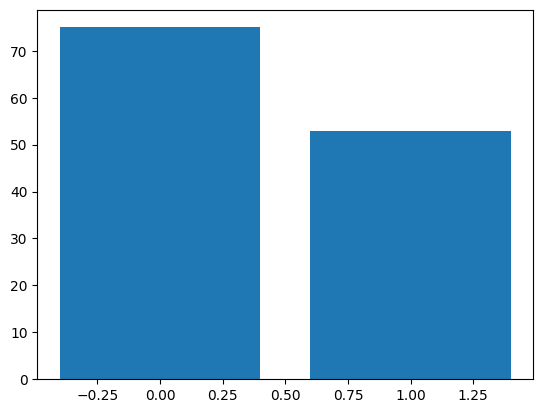

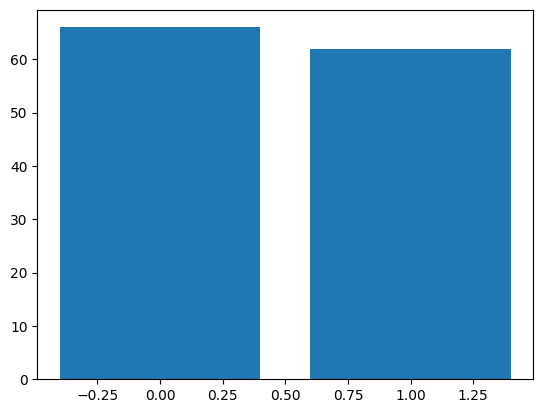

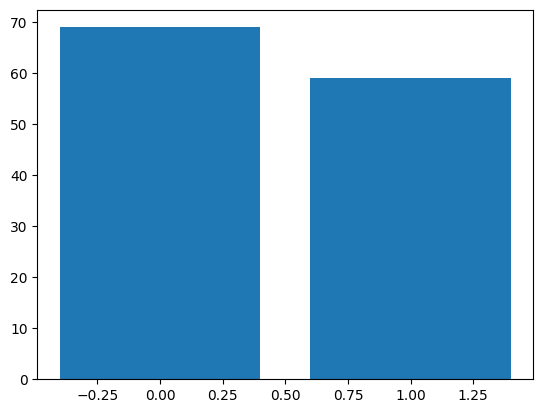

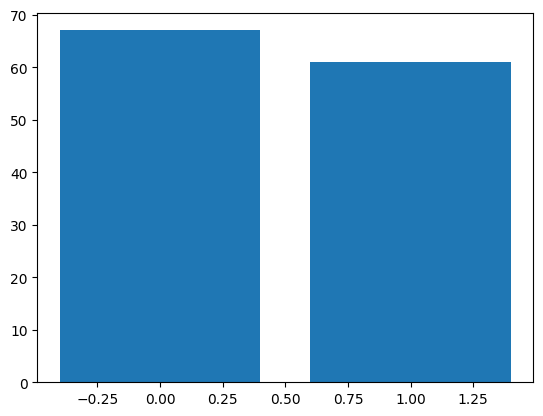

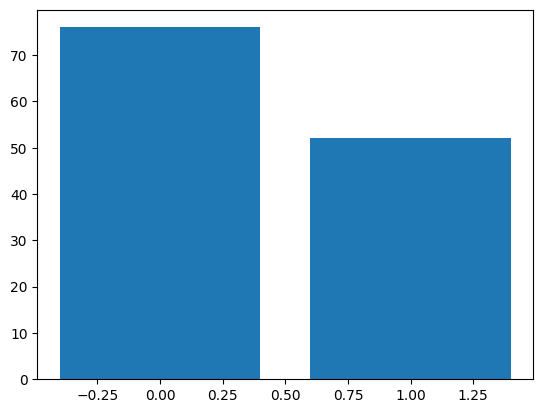

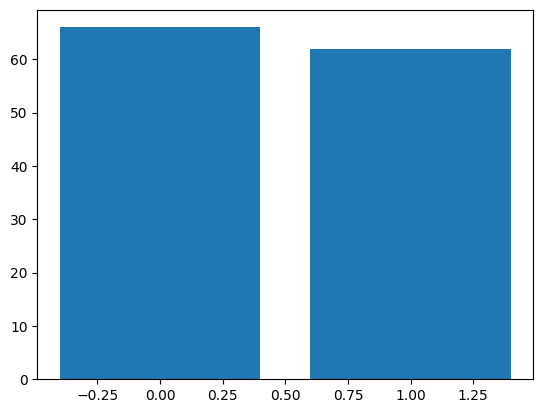

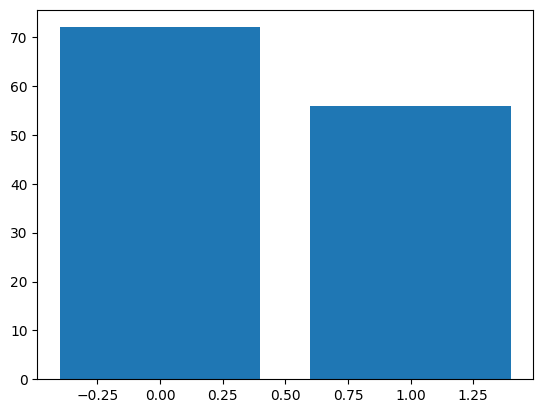

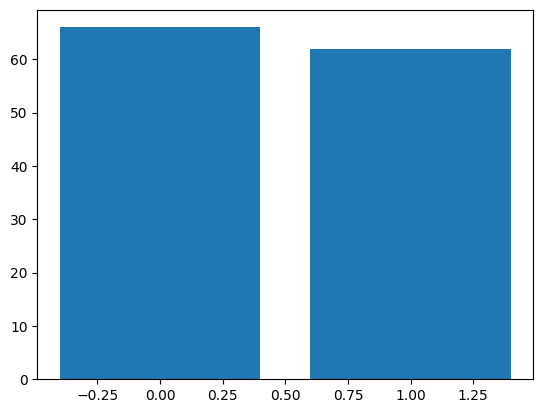

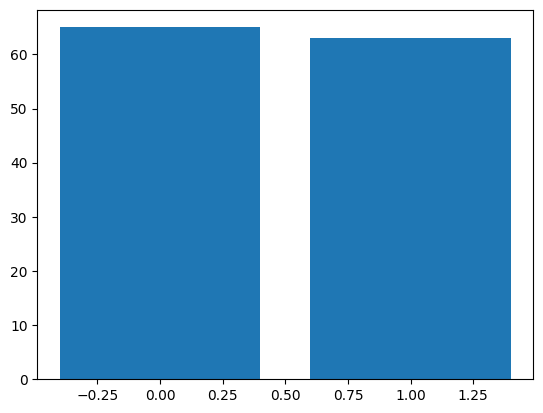

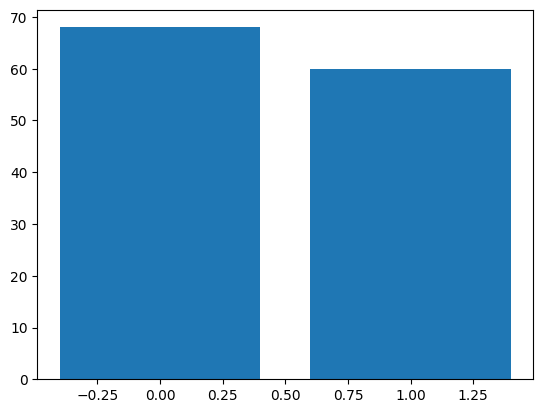

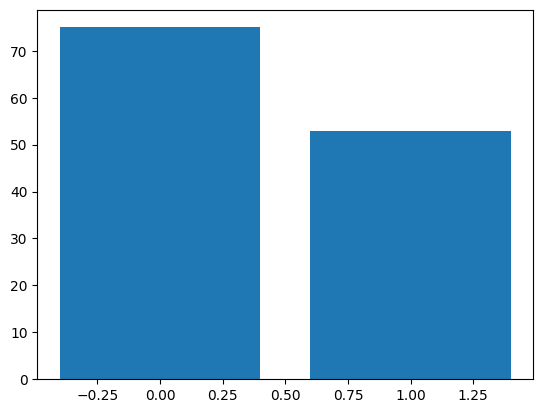

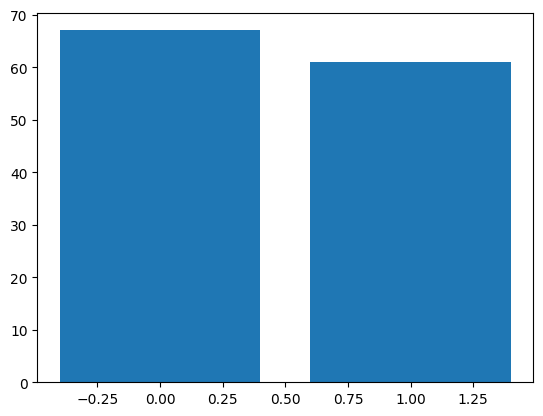

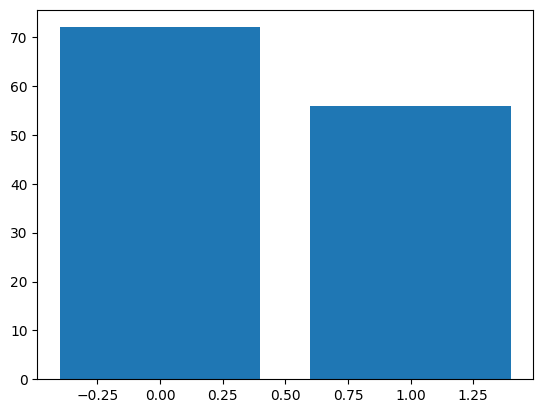

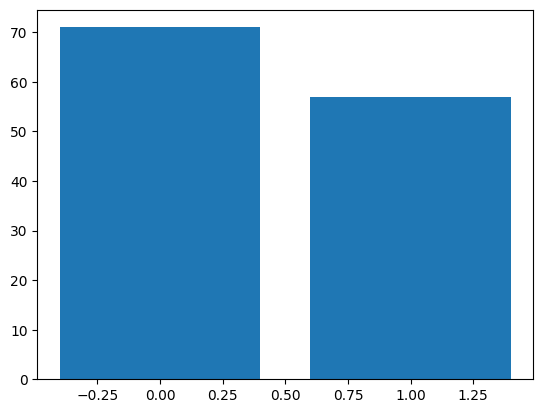

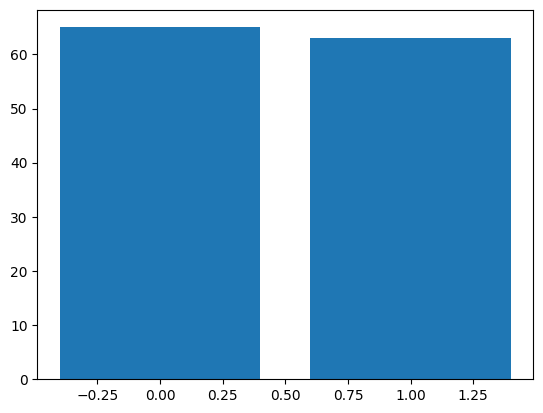

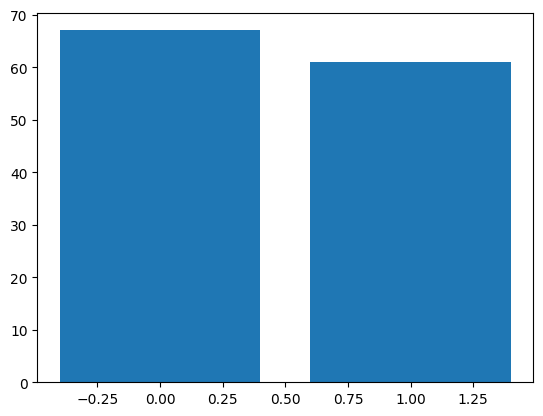

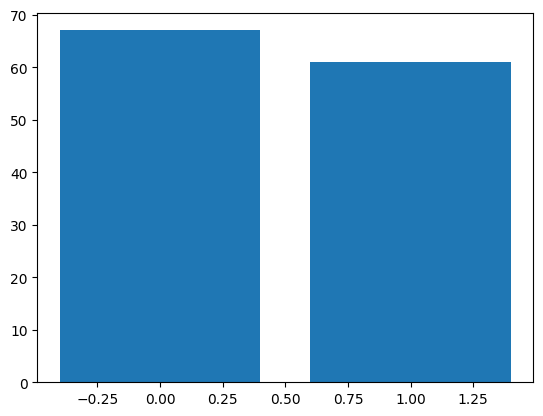

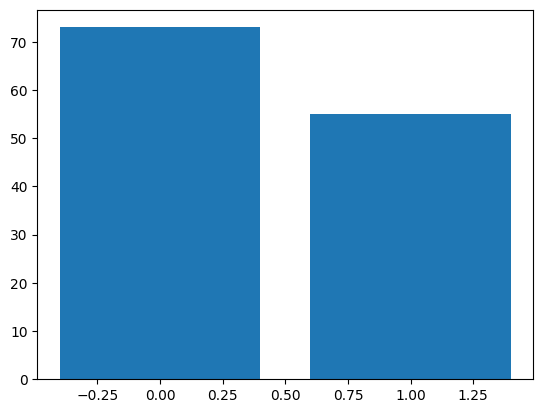

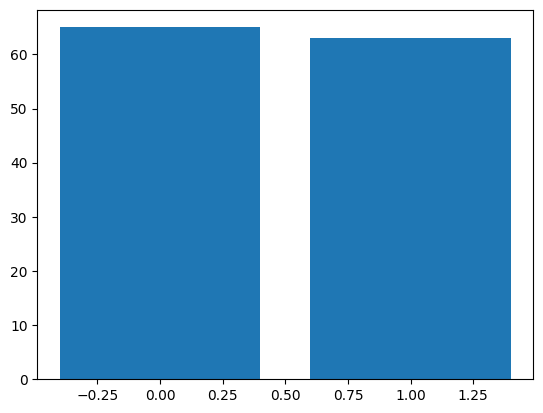

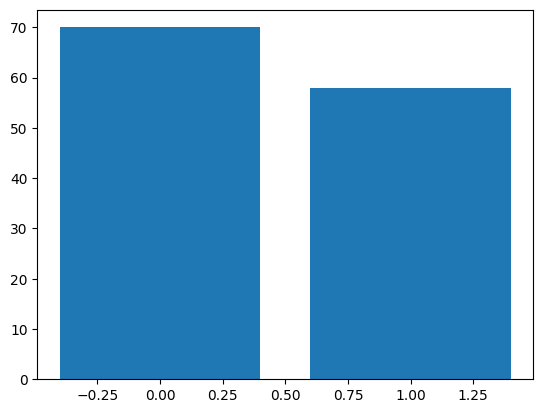

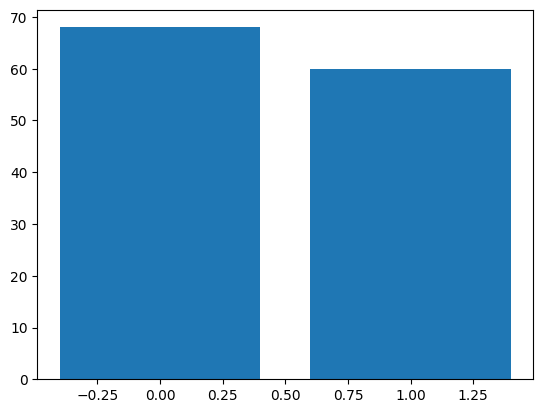

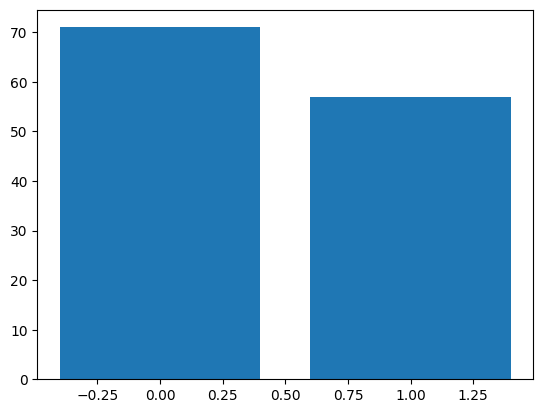

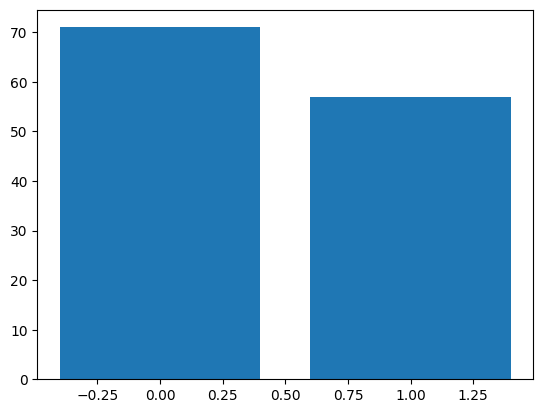

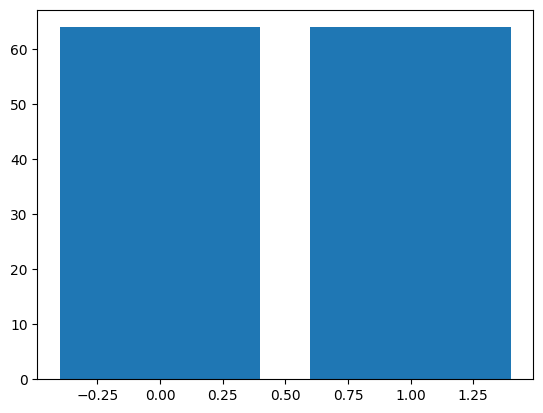

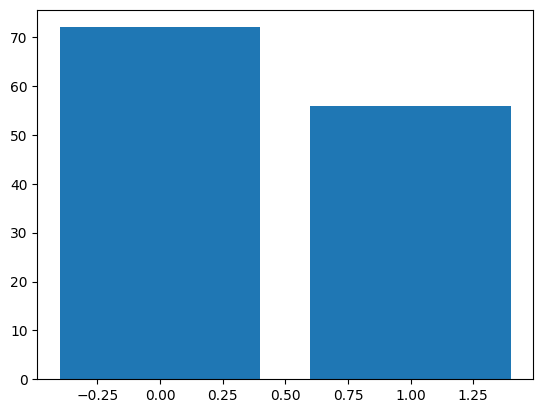

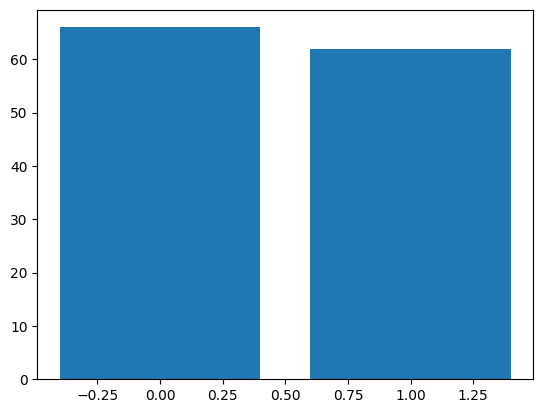

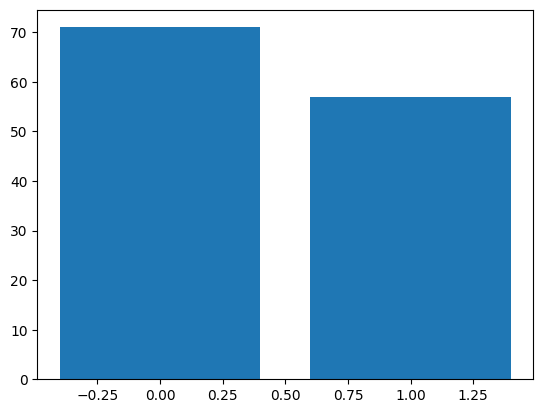

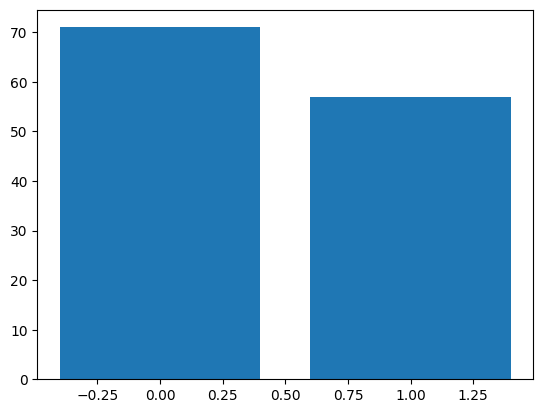

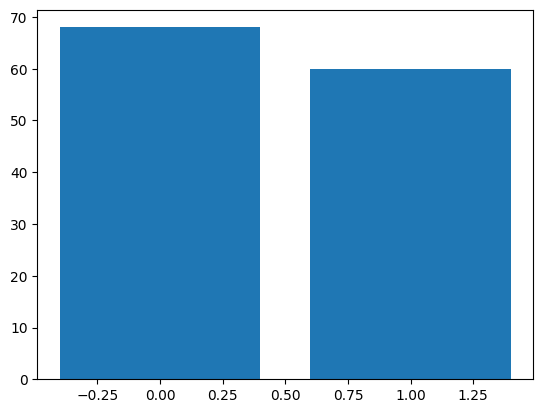

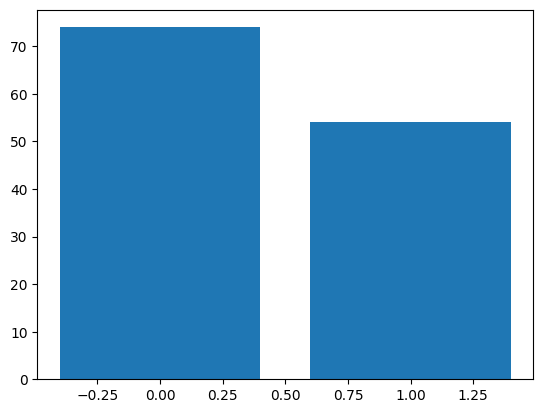

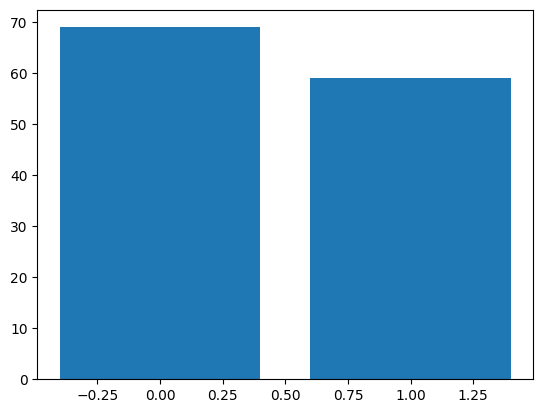

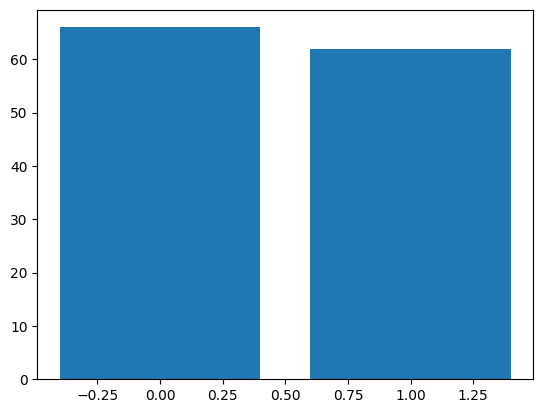

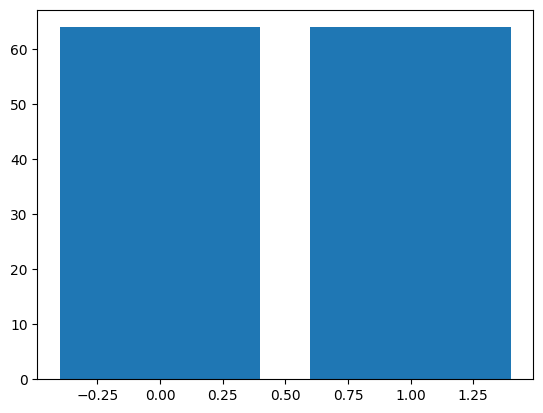

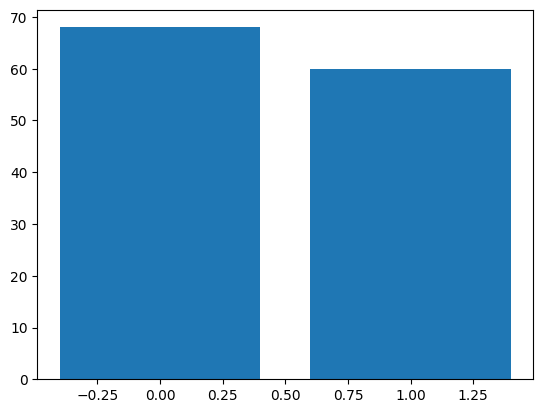

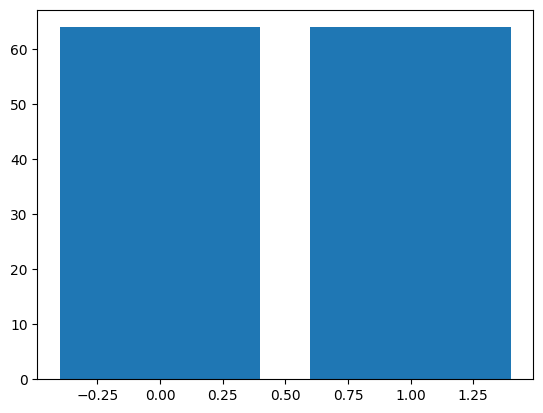

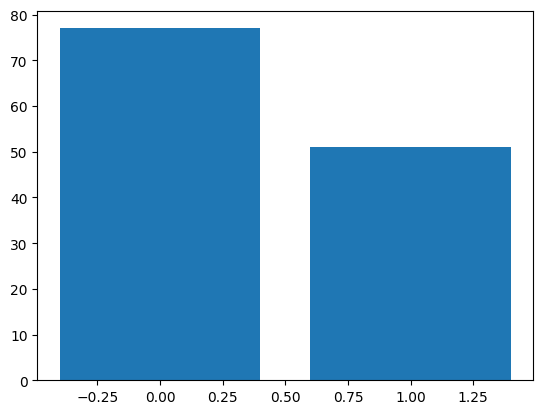

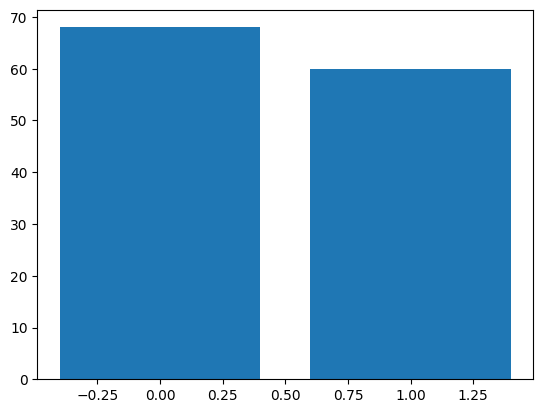

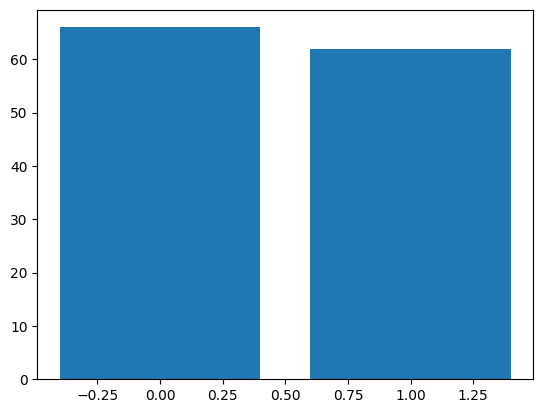

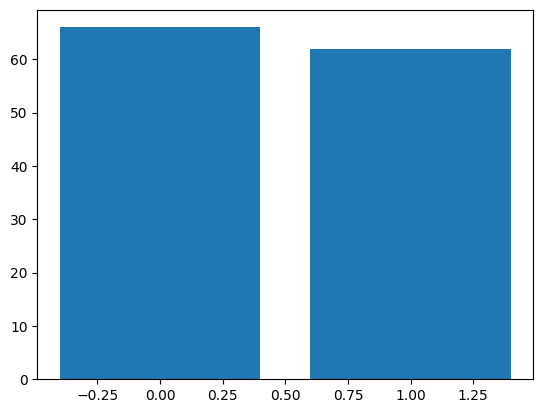

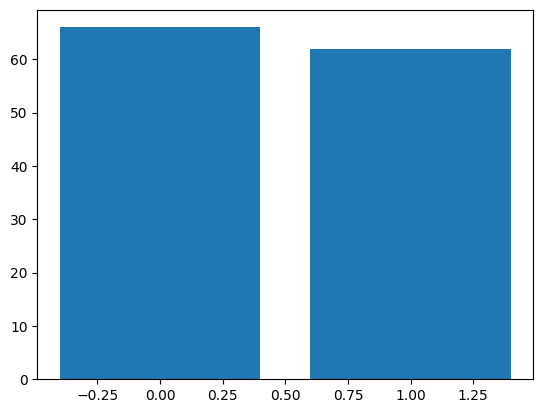

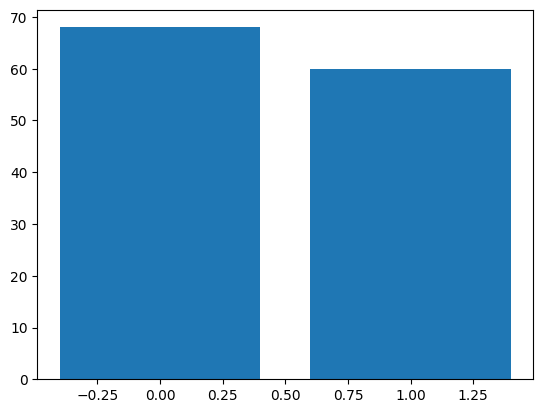

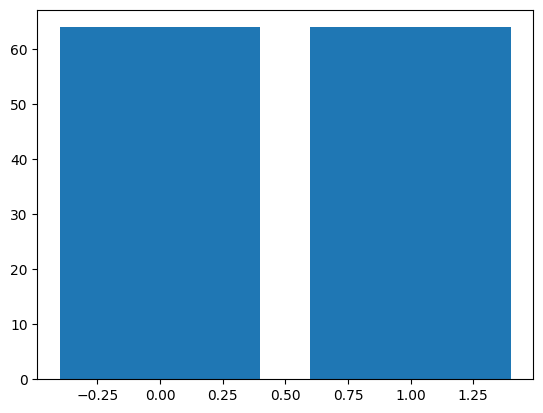

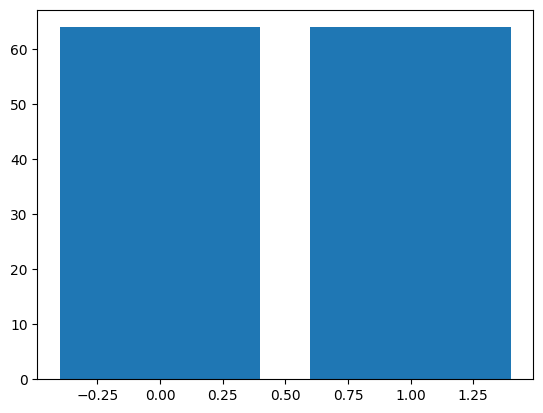

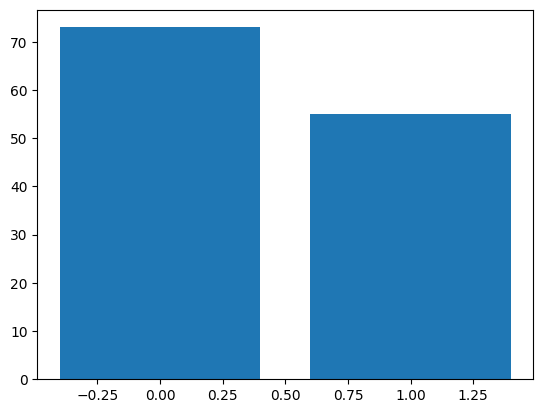

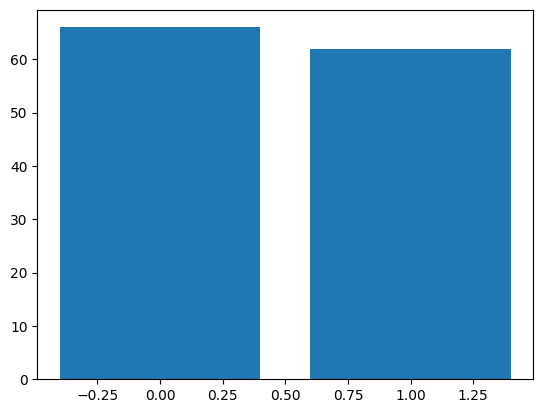

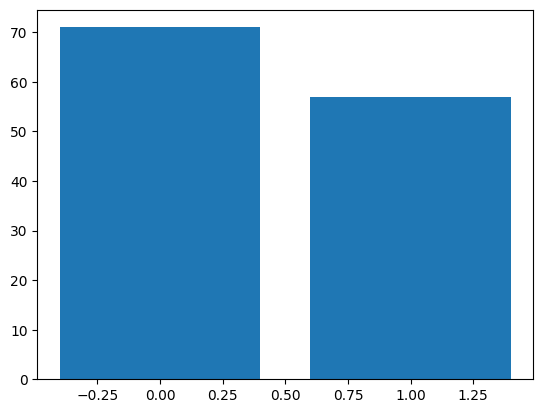

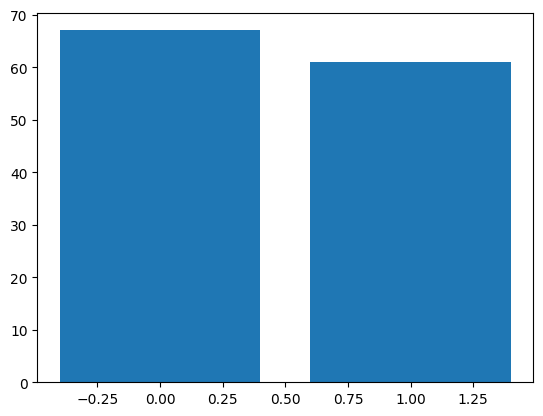

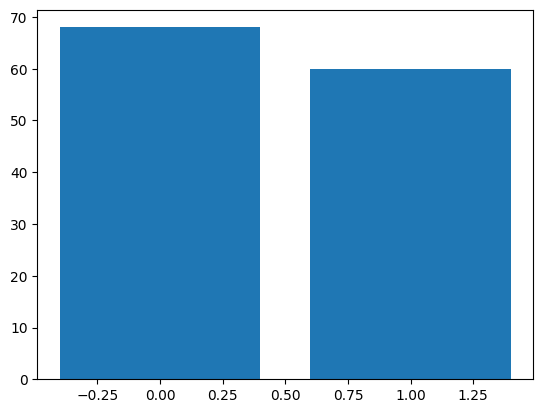

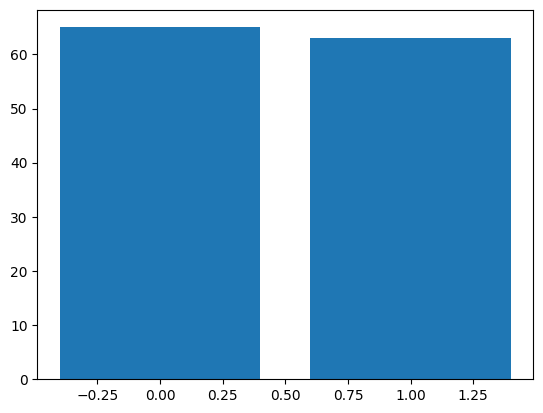

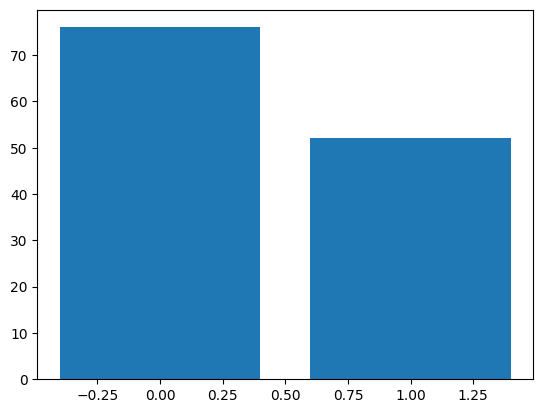

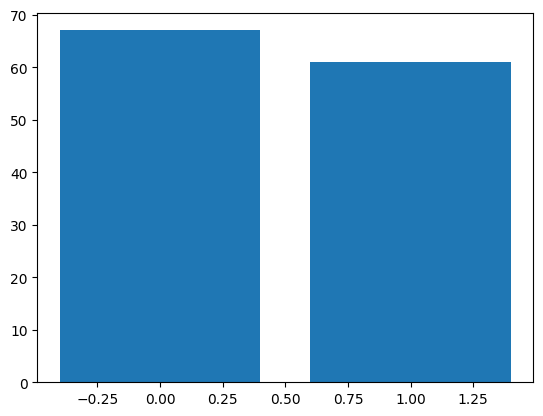

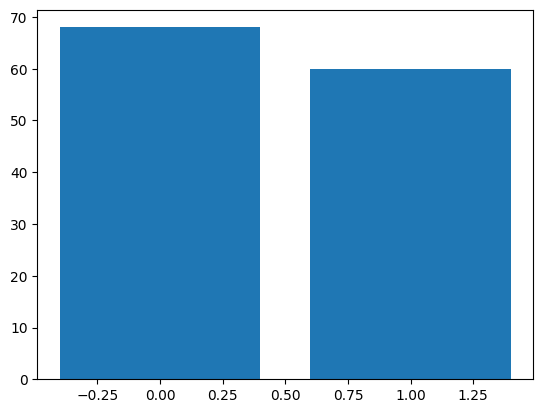

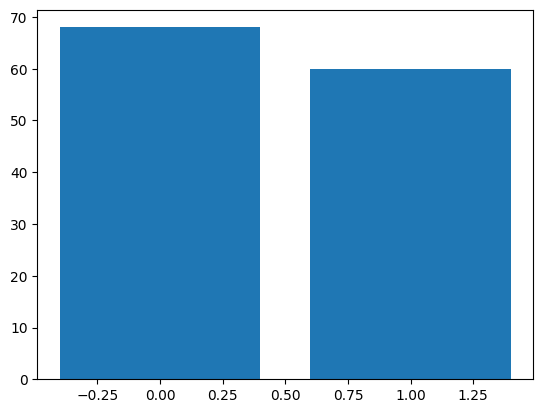

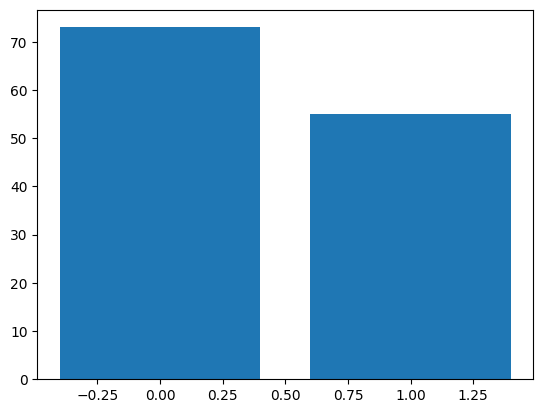

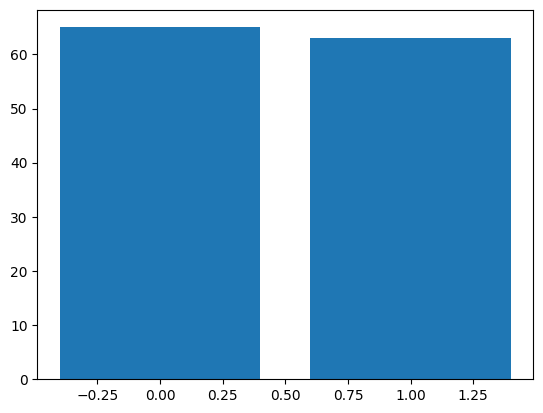

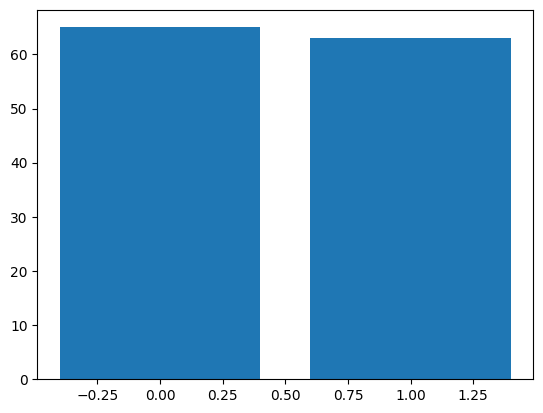

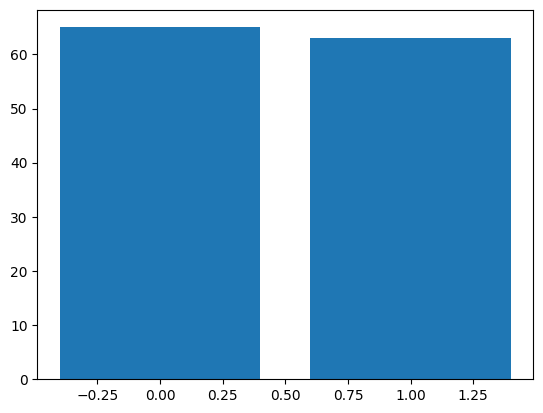

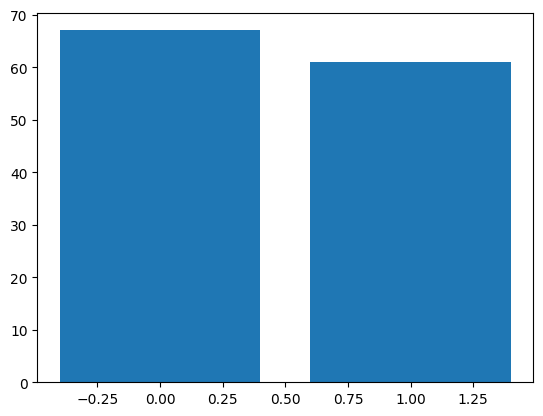

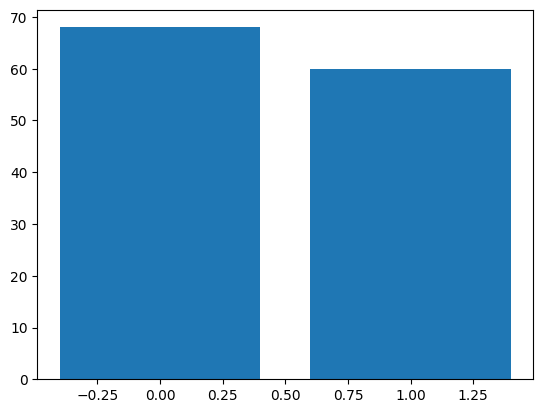

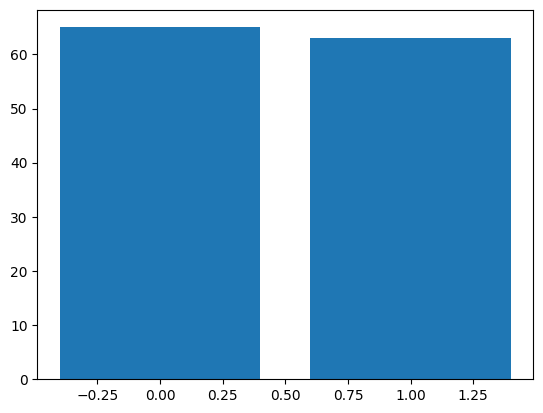

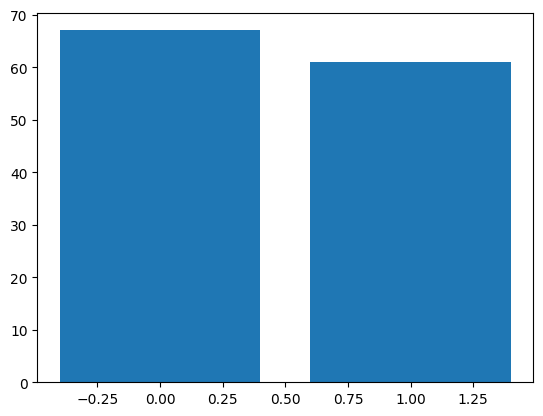

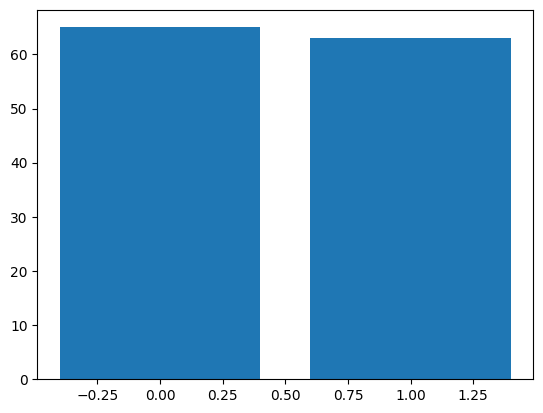

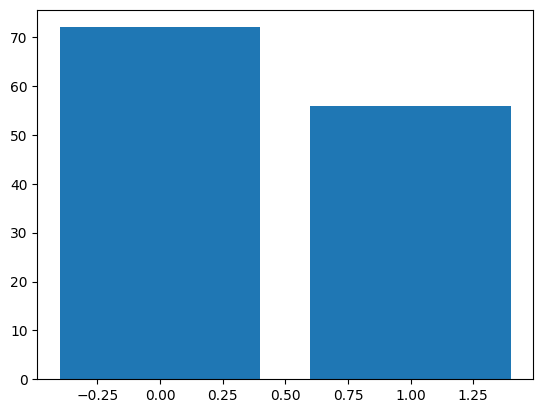

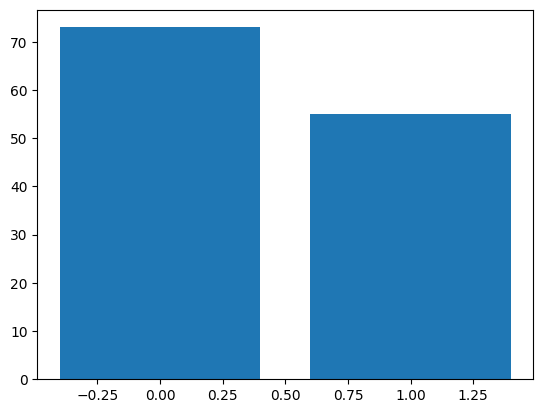

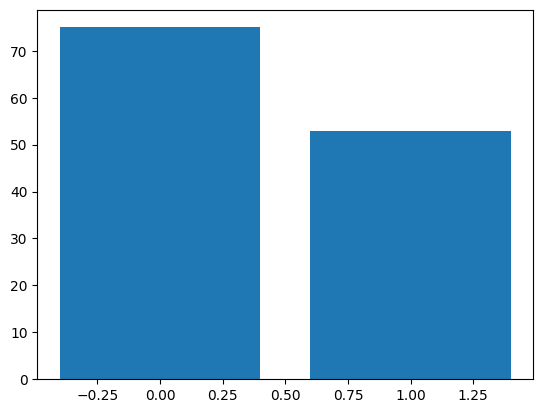

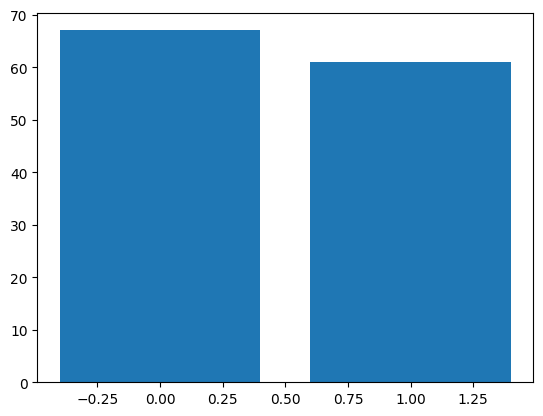

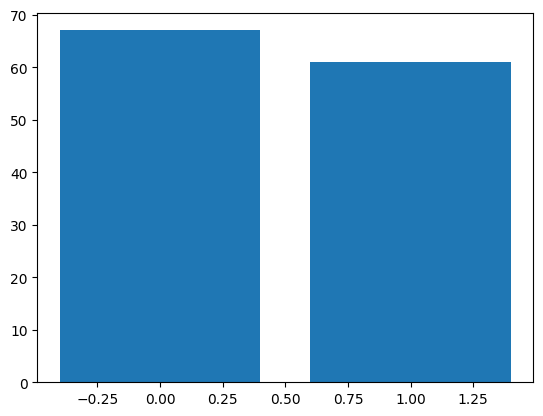

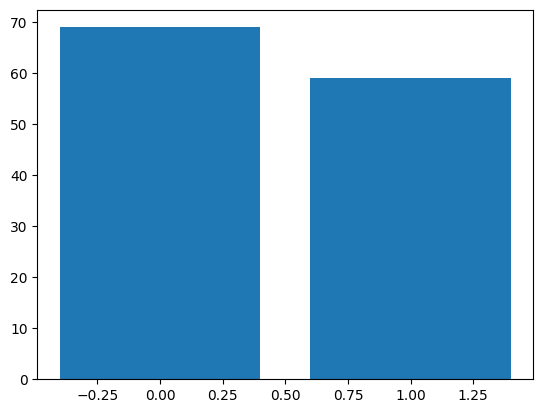

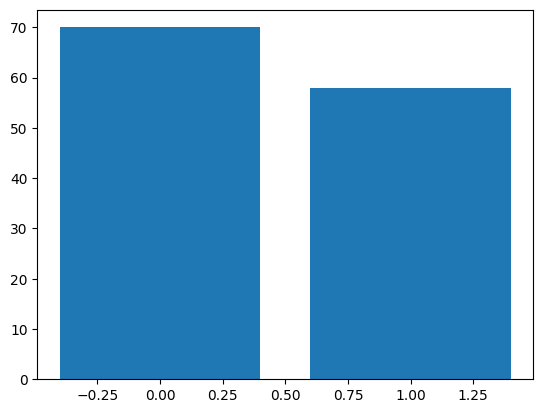

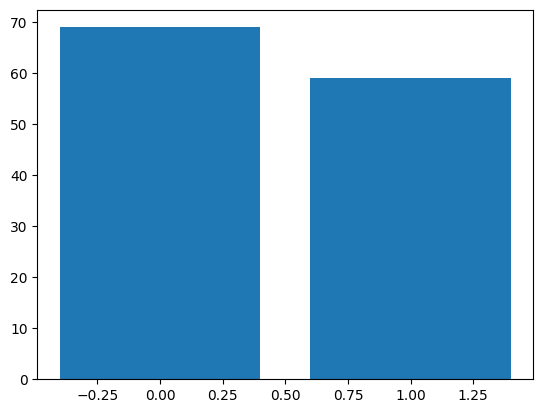

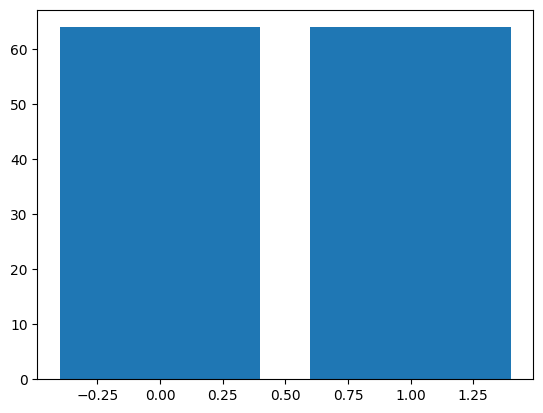

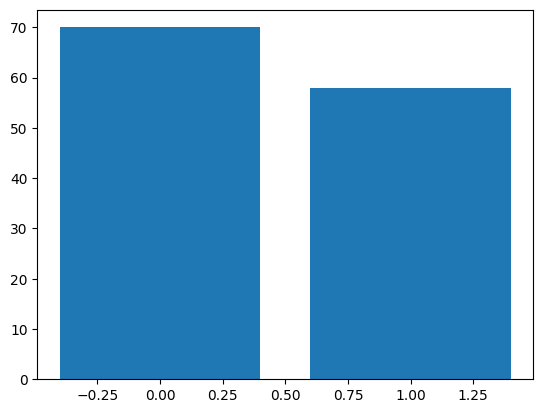

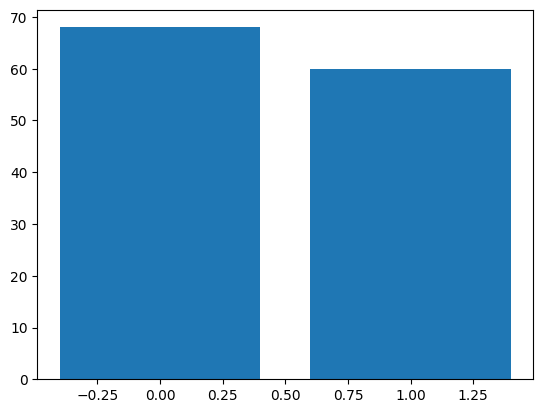

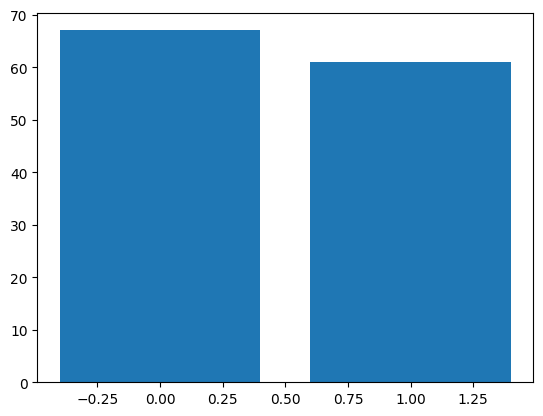

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\multiprocessing\util.py", line 205, in __call__
    def __call__(self, wr=None,
  File "_pydevd_bundle/pydevd_cython.pyx", line 1457, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle/pydevd_cython.pyx", line 1758, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\debugpy\_vendored\pydevd\_pydev_bundle\pydev_is_thread_alive.py", line 10, in is_thread_alive
    return not t._is_stopped
KeyboardInterrupt: 


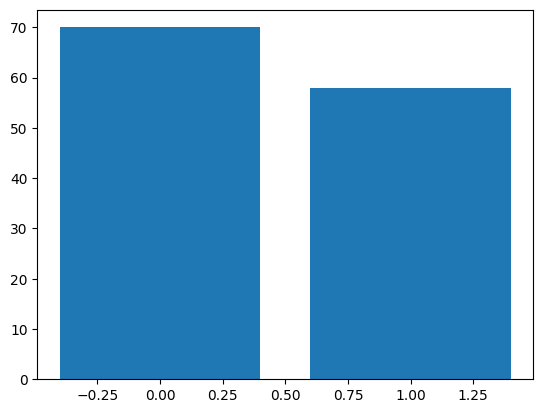

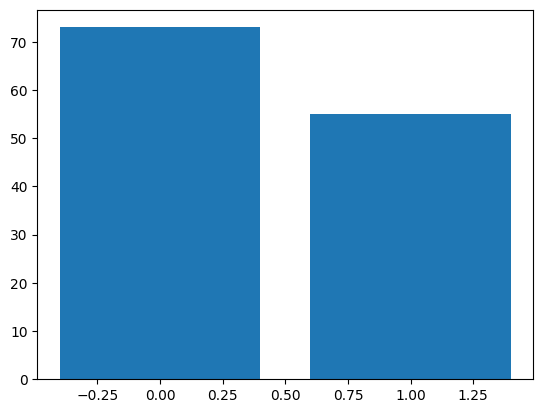

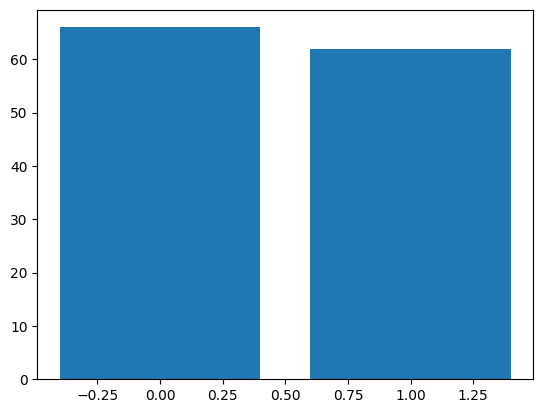

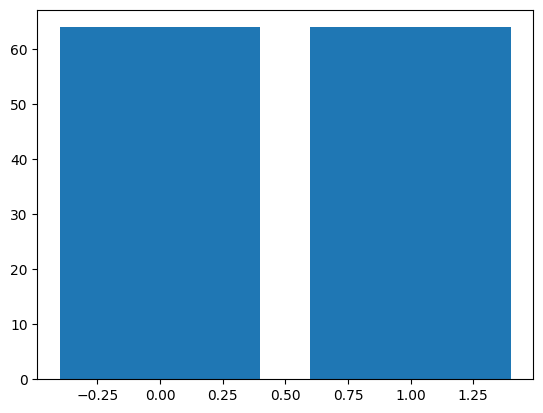

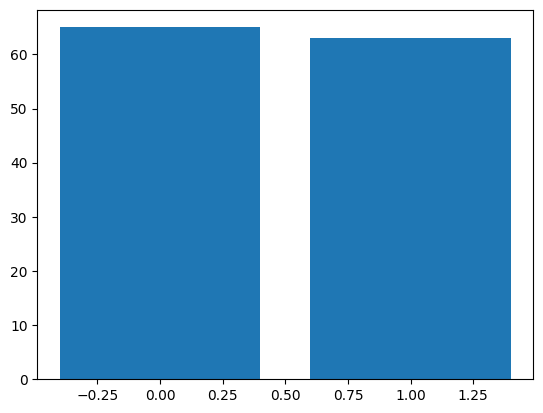

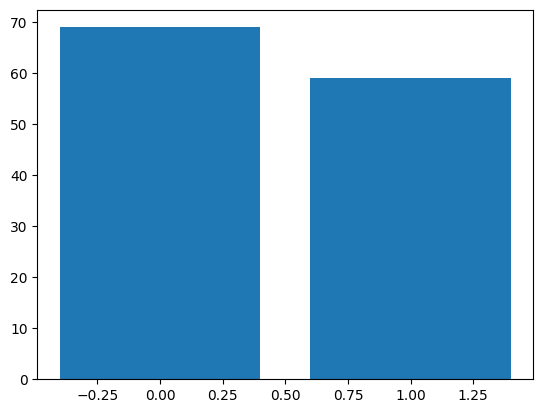

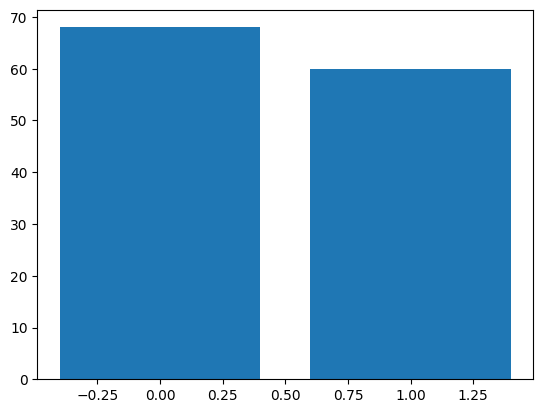

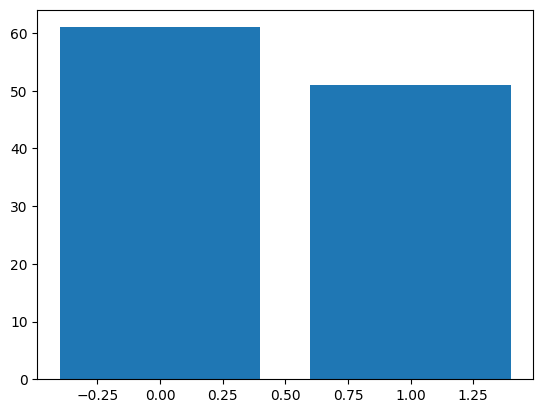

In [560]:
for data,target in train_loader:

    tocount = pd.DataFrame(target.numpy()).value_counts()
    fig, ax =plt.subplots()
    ax.bar([0,1],tocount.values)
    plt.show()

    #get_distribution(test)


In [155]:
type(train)

torch.Tensor

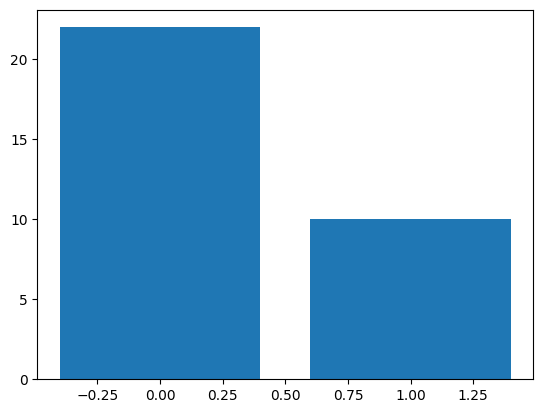

In [152]:
get_distribution(pd.DataFrame(test.numpy()).value_counts())

In [111]:
to_plot.index.tolist()

[(0.0,), (1.0,)]

In [107]:
to_plot.index.values.tolist()

[(0.0,), (1.0,)]

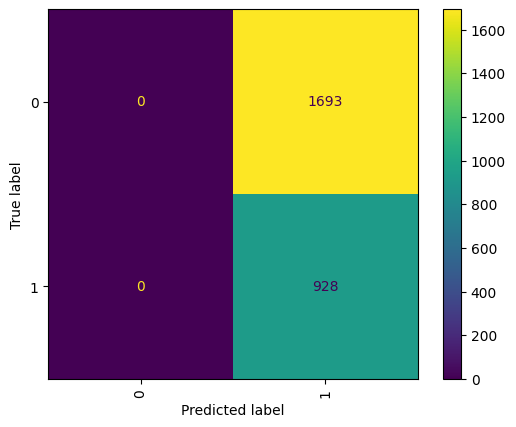

In [698]:
with torch.no_grad():
    data = test_loader.dataset.tensors[0].to(device)
    predicted = model(data).to(device)
    predicted = predicted.cpu()
    predicted = predicted.flatten()
    target = test_loader.dataset.tensors[1].flatten()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(target, predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(xticks_rotation=90)
#disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [704]:
print(f'Precision: {precision_score(target, predicted)}')
print(f'Accuracy: {accuracy_score(target, predicted)}')
print(f'f1_score: {f1_score(target, predicted)}')
print(f'recall_score: {recall_score(target, predicted)}')

Precision: 0.3540633346051126
Accuracy: 0.3540633346051126
f1_score: 0.5229642152719076
recall_score: 1.0


In [709]:
print(f'Precision: {precision_score(target, predicted)}')
print(f'Accuracy: {accuracy_score(target, predicted)}')
print(f'f1_score: {f1_score(target, predicted)}')
print(f'recall_score: {recall_score(target, predicted)}')

Precision: 0.3540633346051126
Accuracy: 0.3540633346051126
f1_score: 0.5229642152719076
recall_score: 1.0


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


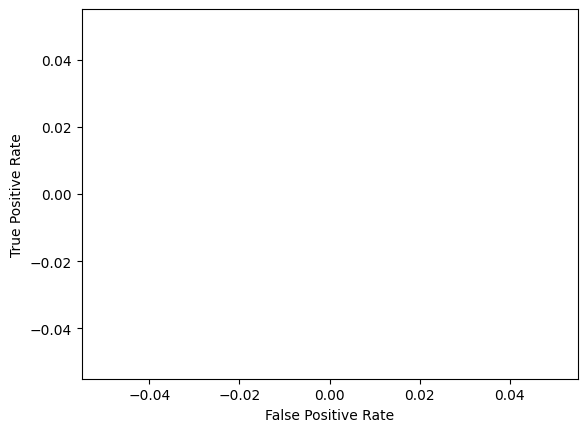

In [705]:
from sklearn.metrics import roc_curve

nn_fpr, nn_tpr, nn_thresholds = roc_curve(predicted, target)
plt.plot(nn_fpr,nn_tpr,marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.show()

In [45]:
study.best_trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.6459366653948875], datetime_start=datetime.datetime(2023, 3, 30, 1, 16, 35, 756185), datetime_complete=datetime.datetime(2023, 3, 30, 1, 16, 58, 526080), params={'lr': 0.0041130297587676085, 'n_layers': 8, 'n_units_l0': 1456, 'n_units_l1': 1579, 'n_units_l2': 1542, 'n_units_l3': 1024, 'n_units_l4': 936, 'n_units_l5': 1804, 'n_units_l6': 351, 'n_units_l7': 35, 'optimizer': 'Adam'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6459366653948875, 1: 0.6459366653948875, 2: 0.6459366653948875, 3: 0.6459366653948875, 4: 0.6459366653948875, 5: 0.6459366653948875, 6: 0.6459366653948875, 7: 0.6459366653948875, 8: 0.6459366653948875, 9: 0.6459366653948875}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'n_layers': IntDistribution(high=10, log=False, low=3, step=1), 'n_units_l0': IntDistribution(high=2048, log=False, low=32, step=1), 'n_units_l1': IntDistribution(high=2048, log=False, low=32

In [42]:
detailed_objective(study.best_trial)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
test_tensor = torch.zeros(len(predicted),10)
test_tensor
count = 0
for x in predicted:
    test_tensor[count][x.item()] = 1
    count += 1
    print(test_tensor)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...

In [ ]:
test_label

torch.return_types.max(
values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
indices=tensor([9, 9, 4,  ..., 9, 8, 9]))

# save model

In [158]:
# Model Saver
from datetime import datetime
numberofmodel = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [ ]:
#calculate accuracy, precision, recall for each index by matching the value of test_tensor (prediction) and test_label (ground truth)
predicted_dict = {}
for x in range(predicted.shape[0]):
    if torch.argmax(test_tensor[0]).item() in predicted_dict.keys():
        predicted_dict[torch.argmax(test_tensor[0]).item()] += 1
    else:
        predicted_dict[torch.argmax(test_tensor[0]).item()] = 1

label_dict = {}
for x in test_loader.dataset:
    if torch.argmax(x[1]).item() in label_dict.keys():
        label_dict[torch.argmax(x[1]).item()] += 1
    else:
        label_dict[torch.argmax(x[1]).item()] = 1
label_dict = dict(sorted(label_dict.items(), key=lambda item: item[0]))

In [ ]:
true_labels = {'No_ADR': 0,
 'ADR_AIU': 1,
 'ADR_Agranulocytosis': 2,
 'ADR_FDE': 3,
 'ADR_Juandice': 4,
 'ADR_MPeruption': 5,
 'ADR_MPexanthema': 6,
 'ADR_SJSI': 7,
 'ADR_SJSII': 8,
 'ADR_TEN': 9}

 #switch true_labels keys an values
true_labels = {v: k for k, v in true_labels.items()}
true_labels

{0: 'No_ADR',
 1: 'ADR_AIU',
 2: 'ADR_Agranulocytosis',
 3: 'ADR_FDE',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

In [ ]:
list(df_labels.columns)

['ADR_AIU',
 'ADR_Agranulocytosis',
 'ADR_FDE',
 'ADR_Juandice',
 'ADR_MPeruption',
 'ADR_MPexanthema',
 'ADR_SJSI',
 'ADR_SJSII',
 'ADR_TEN',
 'No_ADR']

In [ ]:
predicted_dict

{9: 2621}

In [ ]:
label_dict

{2: 1, 4: 103, 5: 133, 6: 350, 7: 64, 8: 277, 9: 1693}

In [ ]:
#remove the keys in true_labels that are not the keys in label_dict
true_labels = {k: v for k, v in true_labels.items() if k in label_dict.keys()}
true_labels

{2: 'ADR_Agranulocytosis',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

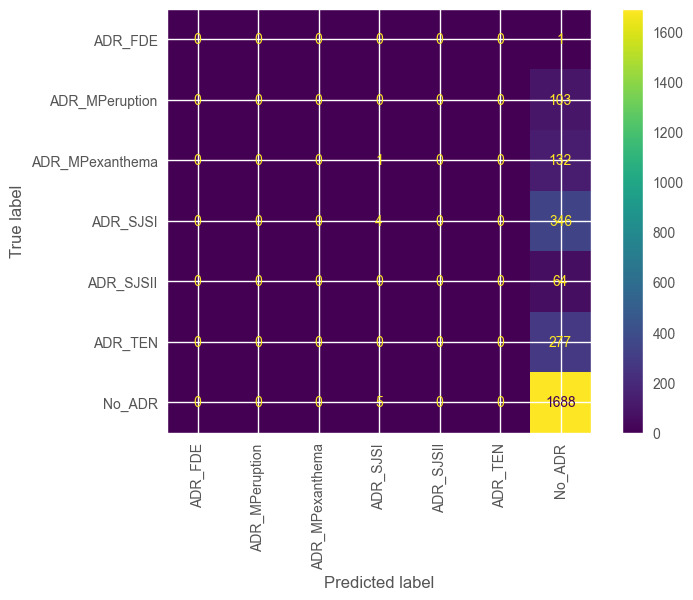

In [ ]:
classes = list(df_labels.columns)

#remove the value in list(df_labels.columns) that got the sum of 0 in df_labels.sum(0)
for x in list(df_labels.columns):
    if df_labels[x].sum(0) == 0:
        classes.remove(x)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(test_label[1], predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
disp.plot(xticks_rotation=90)
disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(test_label[1], predicted, target_names=classes)
print(cr)

                 precision    recall  f1-score   support

        ADR_FDE       0.00      0.00      0.00         1
 ADR_MPeruption       0.00      0.00      0.00       103
ADR_MPexanthema       0.00      0.00      0.00       133
       ADR_SJSI       0.40      0.01      0.02       350
      ADR_SJSII       0.00      0.00      0.00        64
        ADR_TEN       0.00      0.00      0.00       277
         No_ADR       0.65      1.00      0.78      1693

       accuracy                           0.65      2621
      macro avg       0.15      0.14      0.12      2621
   weighted avg       0.47      0.65      0.51      2621



c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
f = open(f"../4 - Training & Testing/models/model_{numberofmodel}.txt","w")
f.writelines(str(model.parameters))
f.writelines("\n------------------\n")
f.writelines(str(optimizer))
f.writelines("\n------------------\n")
f.write(str(loss_fn))
f.writelines("\n------------------\n")
f.write("all_train_loss"+ str(allepoch_train_loss))
f.writelines("\n------------------\n")
f.write(""+str(allepoch_test_acc))
f.writelines("\n------------------\n")
f.write("all_train_loss"+str(allepoch_train_acc))
f.writelines("\n------------------\n")
f.write(cr)
f.close()

In [11]:
torch.save(model.state_dict(),f"../4 - Training & Testing/models/model_{numberofmodel}.pt")

NameError: name 'numberofmodel' is not defined

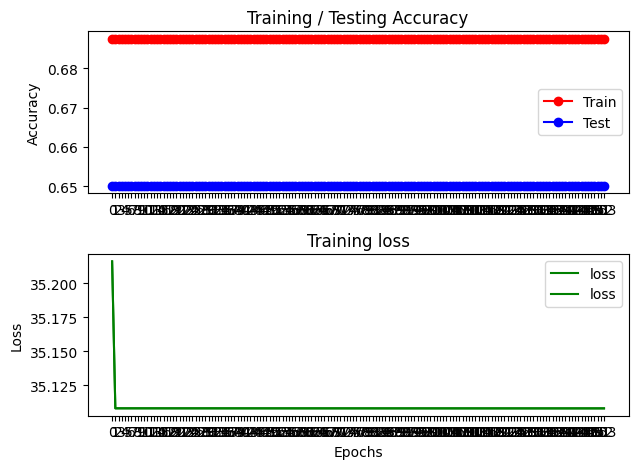

In [159]:
fig, ax = plt.subplots(2,1)
#plt.style.use('ggplot')

ax[0].set_title("Training / Testing Accuracy")
ax[0].plot(allepoch_train_acc, 'red',label='Train',marker='o')
ax[0].plot(allepoch_test_acc,'blue',label='Test',marker='o')
ax[0].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[0].set_ylabel("Accuracy")
ax[0].legend()
#ax[0].text(4,1,f"Model: {numberofmodel}")


ax[1].set_title("Training loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[1].set_ylabel("Loss")
ax[1].legend()
#plt.show()

plt.tight_layout()#h_pad = 3, w_pad=3)
plt.savefig(f"../4 - Training & Testing/models/model_{numberofmodel}.png")

In [ ]:
# fig, ax = plt.subplots()
# ax.bar(list(correctresult.keys()),list(correctresult.values()),label="Correct",bottom=list(wrongresult.values()))
# ax.bar(list(wrongresult.keys()),list(wrongresult.values()),label="Wrong")
# ax.legend()
# #plt.text(1,1,"test")
# # for i in range(len(list(correctresult.keys()))):
# #     plt.text(i,list(correctresult.values())[i],list(correctresult.values())[i])
# # for i in range(len(list(wrongresult.keys()))):
# #     plt.text(i,list(wrongresult.values())[i],list(wrongresult.values())[i])
# plt.show()